In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import make_classification
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from keras.layers import Input, Dense
from keras.models import Model
from sklearn_pandas import gen_features, DataFrameMapper, CategoricalImputer, FunctionTransformer
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn_pandas import gen_features
from utils.pandas_feature_union import PandasFeatureUnion
from utils import process as p
from utils import diagnosis as d

Using TensorFlow backend.


In [2]:
data_path = '../data/'
raw = pd.read_csv(data_path+'train.csv')
y = raw['SalePrice']
X = raw.copy()
cat_features, cont_features, dates = p.tidy_features_type()

In [3]:
# turn into a string to prevent error down the line
X['MSSubClass'] = X['MSSubClass'].astype(str)
X = p.transform_dates(X, dates)
cont_features.extend(['time_since_built', 'time_since_remod', 'time_since_garage'])
remove_cols = dates + ['date_sold', 'SalePrice', 'Id']
X = X.drop(remove_cols, 1)

print(f"check design matrix dimensions: {len(cat_features) + len(cont_features) + 1 == X.shape[1]}")

# outliers
index_outliers = (X.time_since_built < 0) | (X.time_since_garage < 0) | (X.time_since_remod < 0)
print("#outliers: ", index_outliers.sum())
X = X[np.logical_not(index_outliers)]
y = y[np.logical_not(index_outliers)]

check design matrix dimensions: True
#outliers:  1


In [4]:
# continuous features: impute nulls, scale 
transf_cont = gen_features(
    columns=[[c] for c in cont_features],
    classes=[{'class': SimpleImputer, 'strategy':'mean'}, 
             {'class': StandardScaler}
            ])

# categorical features: impute nulls, OHE
transf_cat = [([c], 
               [
                   CategoricalImputer(strategy='constant', fill_value='missing'), 
                   OneHotEncoder(handle_unknown='ignore', sparse=False)
               ]) 
              for c in cat_features]

# We may want to OHE where nulls were before imputing
# cat_features are imputed with "missing" value so no need to do that for them
ohe_nulls_features = cont_features.copy() 
transf_null = [
                ([c], [MissingIndicator(features="all"), 
                       FunctionTransformer(int)], 
                 {'alias':f"{c}_missing"}
                ) for c in ohe_nulls_features]

mapper_main = DataFrameMapper(transf_cont + transf_cat, input_df=True, df_out=True)
mapper_null = DataFrameMapper(transf_null, input_df=True, df_out=True)

preprocess = PandasFeatureUnion([('main', mapper_main), ('null', mapper_null)])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
preprocess.fit(X_train)
X_train = preprocess.transform(X_train)
X_test = preprocess.transform(X_test)

In [6]:
vthresh = p.VarianceThresh() # default: remove single values
vthresh.fit(X_train)
X_train = vthresh.transform(X_train)
X_test = vthresh.transform(X_test)           

In [7]:
import keras
from keras.utils.vis_utils import plot_model
import tensorflow as tf
# from keras_tqdm import TQDMNotebookCallback
# from keras.callbacks import TensorBoard

In [8]:
# # def auroc(y_true, y_pred):
# #     return tf.py_function(, (y_true, y_pred), tf.double)

In [9]:
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(363, activation='relu')(input_layer)
x = Dense(100, activation='relu')(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
output_layer = Dense(1, activation='linear')(x)

optimiser = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, 
                                  epsilon=None, decay=0.0, amsgrad=False)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=optimiser,
              loss='mean_squared_error',
              metrics=['mean_absolute_error'])

Instructions for updating:
Colocations handled automatically by placer.


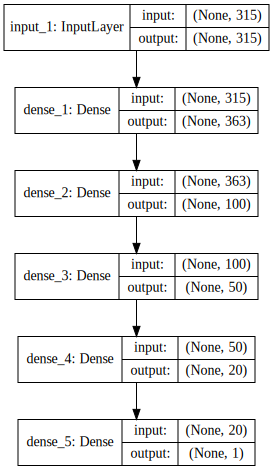

In [10]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [11]:
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.title('loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

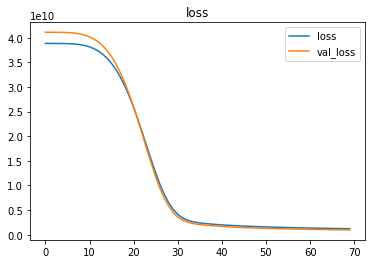

In [12]:
history = model.fit(X_train, y_train, epochs=70, verbose=0, validation_split=0.2,
                   callbacks=[plot_losses])
y_pred_train = np.array([x[0] for x in model.predict(X_train)])
y_pred_test = np.array([x[0] for x in model.predict(X_test)])

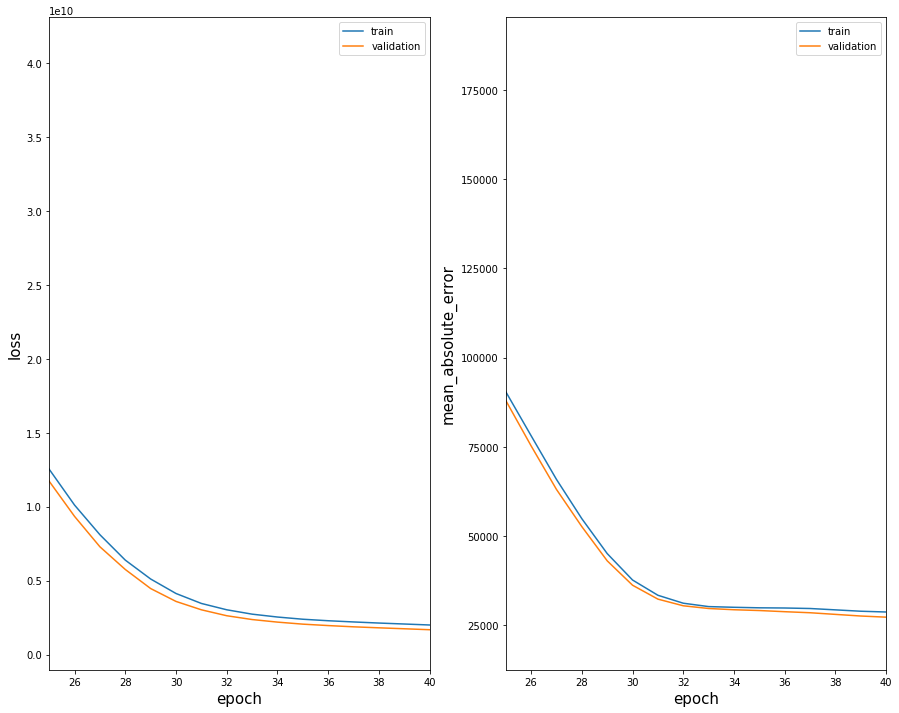

In [13]:
axes = d.plot_metrics_keras(history)
for a in axes:
    a.set_xlim([25,40])

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

metric_func = mean_squared_error
perf_train = metric_func(y_train, y_pred_train)
perf_test = metric_func(y_test, y_pred_test)
df_perf = pd.Series([perf_train, perf_test], index=['train', 'test'])

baseline_estimator = DummyRegressor(strategy='mean')
df_baseline = d.model_performance(baseline_estimator, metric_func, X_train, X_test, 
                                                       y_train, y_test)

print(metric_func.__name__)
d.baseline_comparison(df_perf, df_baseline).round(2)

mean_squared_error


,model,baseline,difference,uplift_percent
train,1.159762e+09,6.366570e+09,5.206808e+09,81.78
test,1.751454e+09,6.090787e+09,4.339333e+09,71.24


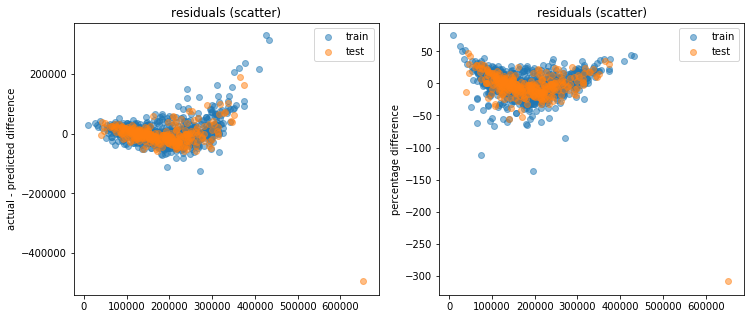

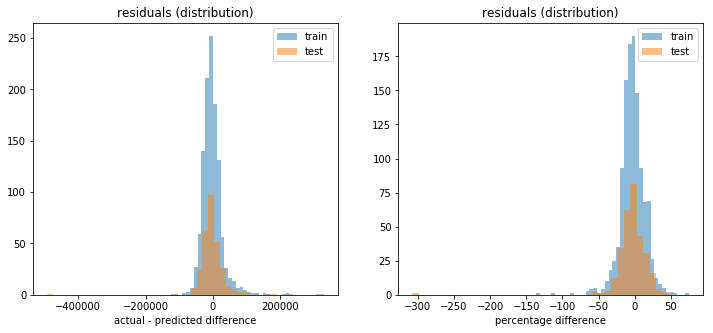

In [15]:
df_summary = d.df_regression_summary(y_train, y_test, y_pred_train, y_pred_test)
d.plot_residuals(df_summary)